In [95]:
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import os
from collections import defaultdict

In [96]:
#MONTE CARLO on blackjack
env = gym.make('Blackjack-v1', natural=True, sab=True)


In [97]:
def policy_player(state):
  if state[0] >= 20:
    return 0
  else:
    return 1

In [98]:
def is_natural(state):#return 1 if natural blackjack, action = 0
  if state[0] == 21:
    return 1, 0
  else:
    return 0, policy_player(state)
  

In [99]:
def generate_episode(env):
  episode = []
  state, _= env.reset()
  done = False
  while not done:
    action = policy_player(state)
    tup = env.step(action)
    next_state, reward, done = tup[0], tup[1], tup[2]
    episode.append((state, action, reward))
    state = next_state
  return episode



In [ ]:
numeps = 20000
V = np.zeros((22,11,2))
alpha = 0.1
for i in range(numeps):
  g = 0
  ep = generate_episode(env)
  print(f'episode {i}: {ep}')
  for j in range(len(ep)-1, -1, -1):
    state, action, reward = ep[j]
    g += reward
    V[state[0], state[1], state[2]] = V[state[0], state[1], state[2]] + alpha*(g - V[state[0], state[1], state[2]])
  print(f'episode {i} value function: {V}')
  print('')
  
print(V)    

In [ ]:
# Prepare for 3D plotting
player_sums = np.arange(0, 22)
dealer_cards = np.arange(0, 11)
usable_ace = np.arange(0, 2)

#plottiing
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(dealer_cards, player_sums)
Z = np.zeros((22, 11))
for i in range(22):
  for j in range(11):
    Z[i,j] = V[i,j,0]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(dealer_cards, player_sums)
Z = np.zeros((22, 11))
for i in range(22):
  for j in range(11):
    Z[i,j] = V[i,j,1]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')

plt.show()





MONTE CARLO CONTROL EXPLORING START


In [102]:
def random_policy_player():
  return lambda state: np.random.choice([0,1])

In [103]:
def exploring_start_episode(env,policy):
  state, _ = env.reset()
  episode = []
  start = True
  while True:
    action = None
    if start:
      action = np.random.choice(env.action_space.n)
      start = False
    else:
      action = policy(state)
    
    next_state, reward, terminated, truncated, _ = env.step(action)
    episode.append((state,action,reward))
    if terminated or truncated:
      break
    
    state = next_state
  return episode
  

In [104]:
def update_q_values(episode,Q,returns,counts):
  state_action_pairs = [(state,action) for state,action,_ in episode]
  for i, (state,action) in enumerate(state_action_pairs):
    if (state,action) not in state_action_pairs[:i]:
      G = sum([reward for _,_,reward in episode[i:]])
      returns[state,action] += G
      counts[state,action] += 1
      Q[state][action] = returns[state,action]/counts[state,action]

In [105]:
def create_greedy_policy(Q,policy):
  def policy(state):
    if state not in Q:
      return np.random.choice([0,1])
    return np.argmax(Q)
  return policy

In [106]:
def mc_exploring_starts(env,numeps,debug = False):
  Q = defaultdict(lambda : np.zeros(env.action_space.n))
  returns = defaultdict(float)
  counts = defaultdict(int)
  for ep in range(1, numeps + 1):
    if debug and ep%10000 == 0:
      print(f'Episode: {ep}')
      
    policy = random_policy_player()
    episode = exploring_start_episode(env,policy)
    update_q_values(episode,Q,returns,counts)
    
  optimal_policy = create_greedy_policy(Q,policy)
  return Q,optimal_policy
    

In [ ]:
env = gym.make("Blackjack-v1", sab = True)
numeps = 500000
Q,optimal_policy = mc_exploring_starts(env,numeps,True)
#value function from Q
V = defaultdict(float)




In [108]:
V = {state: max(actions) for state, actions in Q.items()}

In [ ]:
player_scores = np.arange(12,22)
dealer_showing = np.arange(1,11)
values = np.zeros((len(player_scores),len(dealer_showing)))
for i, player_score in enumerate(player_scores):
  for j, dealer_card in enumerate(dealer_showing):  
    state = (player_score, dealer_card, False)
    if state in V :
      values[i,j] = V[state]

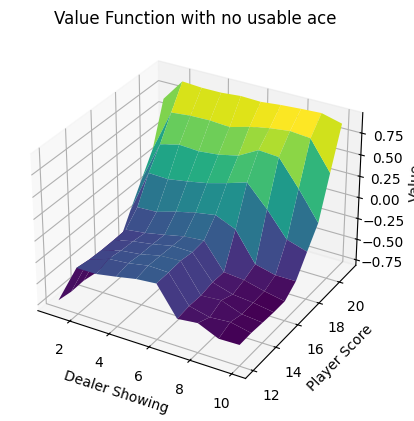

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X,Y = np.meshgrid(dealer_showing,player_scores) 
ax.plot_surface(X,Y,values,rstride=1,cstride=1,cmap='viridis')  
ax.set_xlabel('Dealer Showing') 
ax.set_ylabel('Player Score')
ax.set_zlabel('Value')
ax.set_title('Value Function with no usable ace')
plt.show()  